<a href="https://colab.research.google.com/github/erlichsefi/ScrapeAnything/blob/main/browser_base_translation%20/AutoJavaScript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoGPT with JavaScript

## install selenium & chromium

In [1]:
# According to: https://stackoverflow.com/questions/51046454/how-can-we-use-selenium-webdriver-in-colab-research-google-com
%%capture
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium
apt install chromium-chromedriver
pip install pandas
pip install openai

## util to convert the on screen to data

In [25]:
script_with_logs = """
// Get all elements in the HTML page
const elements = document.getElementsByTagName('*');

// Create an array to store the element details
const elementDetails = [];

// Iterate through each element
for (let i = 0; i < elements.length; i++) {
  const element = elements[i];

  // Get the bounding rectangle of the element
  const rect = element.getBoundingClientRect();

  // Get the text content of the element
  const textContent = element.textContent.trim();

  // Get the tooltip value if it exists
  const tooltip = element.hasAttribute('title') ? element.getAttribute('title') : '';

  // Store the element, its bounding rectangle, text content, and tooltip details
  const elementInfo = {
    element: element,
    rect: rect,
    textContent: textContent,
    ariaLabel: element.hasAttribute('aria-label') ? element.getAttribute('aria-label') : '',
    tooltip: tooltip,
    e_type: element.nodeName
  };
  if (elementInfo.rect.width > 0 && elementInfo.rect.height > 0){
  // Add the element details to the array
   if (elementInfo.tooltip != '' || elementInfo.textContent != '' || elementInfo.ariaLabel != ''){
    elementDetails.push(elementInfo);
    }
  }
}

let parents = elementDetails.map(e=>e.element.parentElement);
let withoutParents = elementDetails.filter(elementDetail=> !parents.includes(elementDetail.element));

// Display the element details
console.log("X,Y,Width,Height,ElementType,textContent,TooltipValue,AriaLabel");
console.log(withoutParents.map( e=> e.rect.x+","+e.rect.y+","+e.rect.width+","+e.rect.height+","+e.e_type+","+e.rect.textContent+","+e.tooltip+","+e.ariaLabel).join("\\n"));
"""

def screen_to_table(wd):
  import pandas as pd
  import io

  script = f"""
  var consoleLogs = [];
  var originalLog = console.log;
  console.log = function(message) {{
      consoleLogs.push(message);
      originalLog.apply(console, arguments);
  }};

  {script_with_logs}

  return consoleLogs;
  """
  logs = wd.execute_script(script)
  return pd.read_csv(io.StringIO("\n".join(logs)), sep=",")

In [21]:
def start_browesr():
  from selenium import webdriver
  from selenium.webdriver.chrome.service import Service

  service = Service(executable_path=r'/usr/bin/chromedriver')
  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--lang=en')
  chrome_options.headless = True
  return webdriver.Chrome(service=service,options=chrome_options)

def web_driver_to_image(wd,prefix=""):
  import re
  import os
  from urllib.parse import urlparse, urlunparse

  url = wd.current_url
  # Parse the URL
  parsed_url = urlparse(url)

  # Remove the query parameters
  clean_url = urlunparse((parsed_url.scheme, parsed_url.netloc, parsed_url.path, "", "", ""))

  file_name = re.sub(r'[^a-zA-Z0-9_-]', '_', clean_url)
  file_name = f"{prefix}_{file_name}.png"

  wd.save_screenshot(file_name)
  return file_name


import os
import base64
from PIL import Image
from IPython.display import display, HTML

def display_images_side_by_side(before_file, after_file):
    if not os.path.isfile(before_file):
        print(f"Error: File '{before_file}' not found.")
        return
    if not os.path.isfile(after_file):
        print(f"Error: File '{after_file}' not found.")
        return

    _, before_ext = os.path.splitext(before_file)
    _, after_ext = os.path.splitext(after_file)
    valid_extensions = ['.png', '.jpg', '.jpeg', '.gif']

    if before_ext.lower() not in valid_extensions:
        print(f"Error: Invalid file type. Only {', '.join(valid_extensions)} are supported.")
        return
    if after_ext.lower() not in valid_extensions:
        print(f"Error: Invalid file type. Only {', '.join(valid_extensions)} are supported.")
        return

    try:
        display_side_by_side([
            (before_file, 'Before'),
            (after_file, 'After')
        ])
    except Exception as e:
        print(f"Error displaying images: {e}")

def display_side_by_side(images_with_titles):
    html = "<style>td img{max-width:100%; max-height:100%;} td.title-cell{text-align:center; font-size:18px;}</style>"
    html += "<table>"
    html += "<tr>"
    for _, title in images_with_titles:
        html += f"<td class='title-cell'>{title}</td>"
    html += "</tr>"
    html += "<tr>"
    for file, _ in images_with_titles:
        image_data = base64.b64encode(open(file, 'rb').read()).decode('utf-8')
        html += f"<td><img src='data:image/png;base64,{image_data}' /></td>"
    html += "</tr>"
    html += "</table>"

    display(HTML(html))




# Tools
base on https://github.com/mpaepper/llm_agents/blob/main/llm_agents/tools/google_search.py

In [37]:
from pydantic import BaseModel

class ToolInterface(BaseModel):
    name: str
    description: str
    web_driver: object


    def use(self) -> str:
        raise NotImplementedError("use() method not implemented")  # Implement in subclass



def example_tool(tool,site,*arg,**kwarg):
  wd = start_browesr()
  wd.get(site)
  b_filename = web_driver_to_image(wd,f"{str(tool.__class__)}_before")
  tool().use(wd,*arg,**kwarg)
  a_filename = web_driver_to_image(wd,f"{str(tool.__class__)}_after")

  display_images_side_by_side(b_filename,a_filename)

In [4]:
def click_on_screen(wd, x, y):
  from selenium.webdriver.common.action_chains import ActionChains

  actions = ActionChains(wd)
  actions.move_by_offset(x, y)
  actions.click()
  actions.perform()
  return wd


class ClickOnCoordinates(ToolInterface):
  """Click on certain coordinate on the screen """

  name = "Click on coordinates on the screen"
  description = "click on x,y coordinates in order to move to the next screen. Input should be a two value x and y."

  def use(self,web_driver:object, x: float, y:float) -> str:
      return click_on_screen(web_driver,x,y)

<ipython-input-21-71a29cc62e3a>:10: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  chrome_options.headless = True


Before,After
,

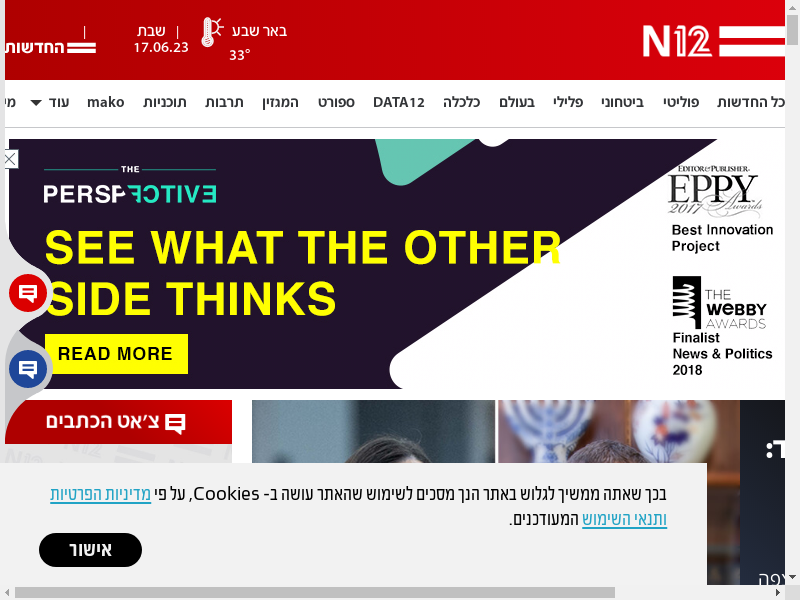
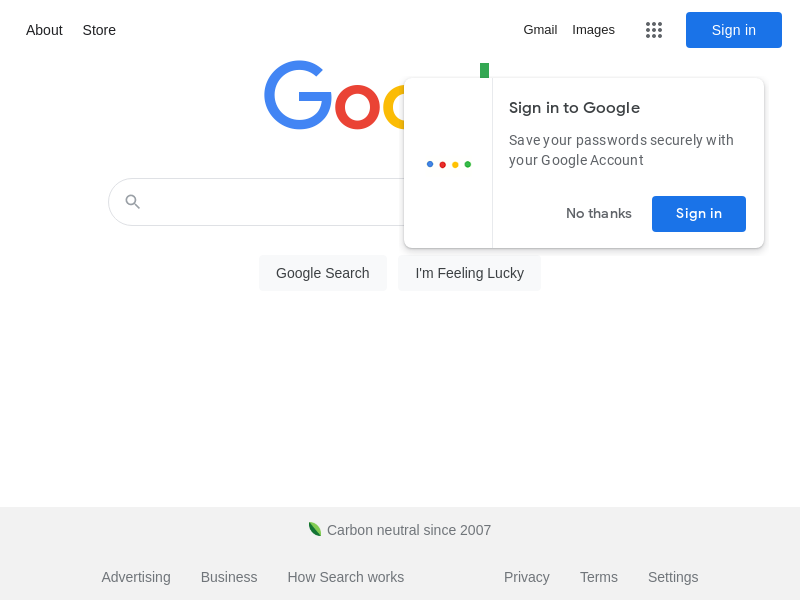

In [38]:
class GoToURL(ToolInterface):
  """ Go to a specific url address """

  name = "Go to a specific url web address"
  description = "Change the url to a provied URL. Input should be single string in URL foramt."


  def use(self,web_driver:object, url: str) -> str:
      web_driver.get(url)
      return web_driver


example_tool(GoToURL,site="https://www.n12.co.il/",url="https://www.google.com/")

<ipython-input-21-71a29cc62e3a>:10: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  chrome_options.headless = True


Before,After
,

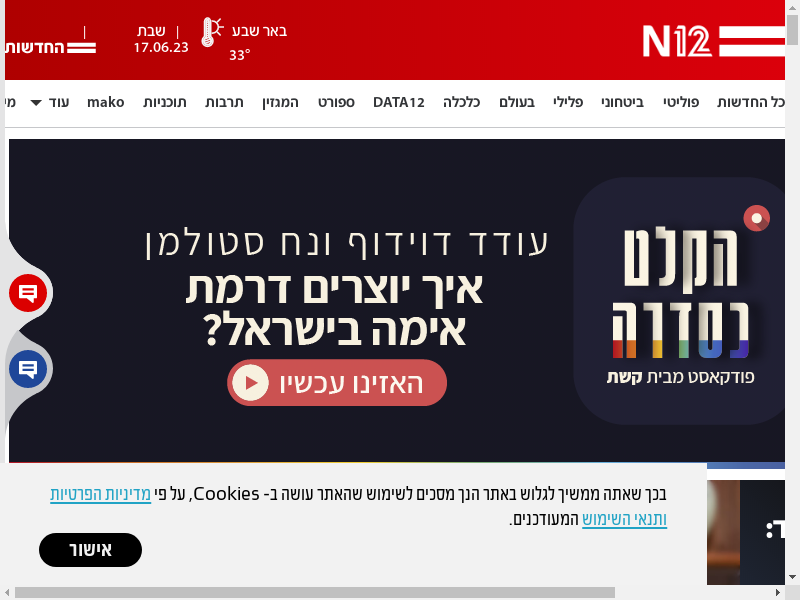
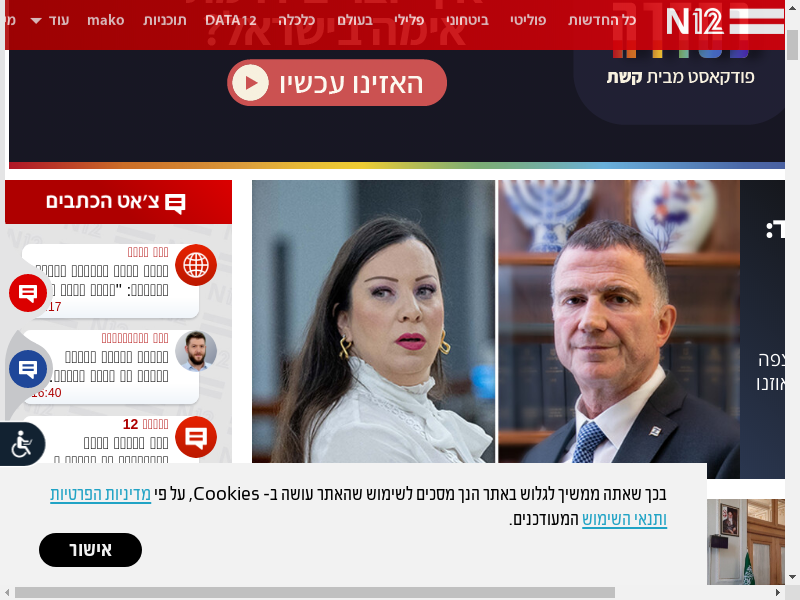

In [34]:
class ScrollDown(ToolInterface):
    """Scroll down the web page by half the screen height"""

    name = "Scroll Down"
    description = "Scroll down the web page by half the screen height"

    def use(self, web_driver: object) -> None:
        # Get the height of the web page
        page_height = web_driver.execute_script("return document.body.scrollHeight")

        # Get the height of the viewport
        viewport_height = web_driver.execute_script("return window.innerHeight")

        # Calculate the scroll distance (half the screen height)
        scroll_distance = viewport_height // 2

        # Scroll down the web page
        web_driver.execute_script(f"window.scrollBy(0, {scroll_distance});")


example_tool(ScrollDown,site="https://www.n12.co.il/")

<ipython-input-21-71a29cc62e3a>:10: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  chrome_options.headless = True


Before,After
,

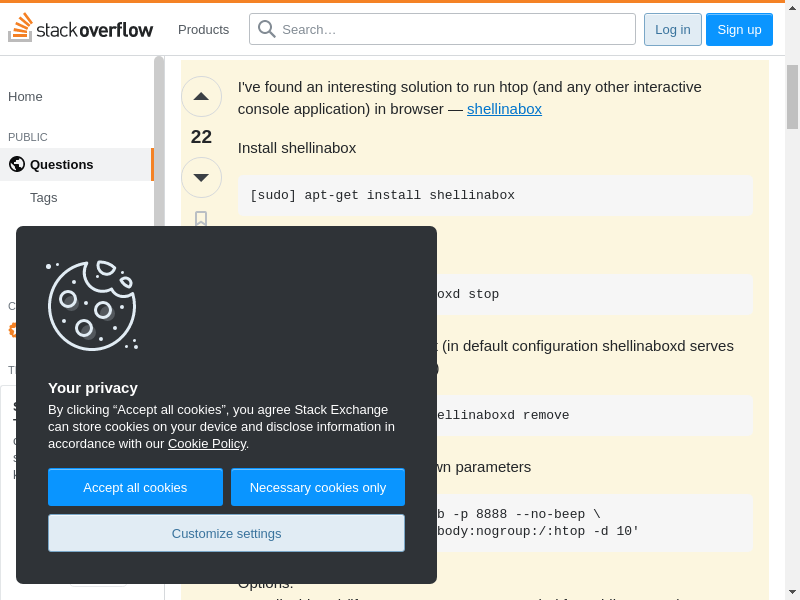
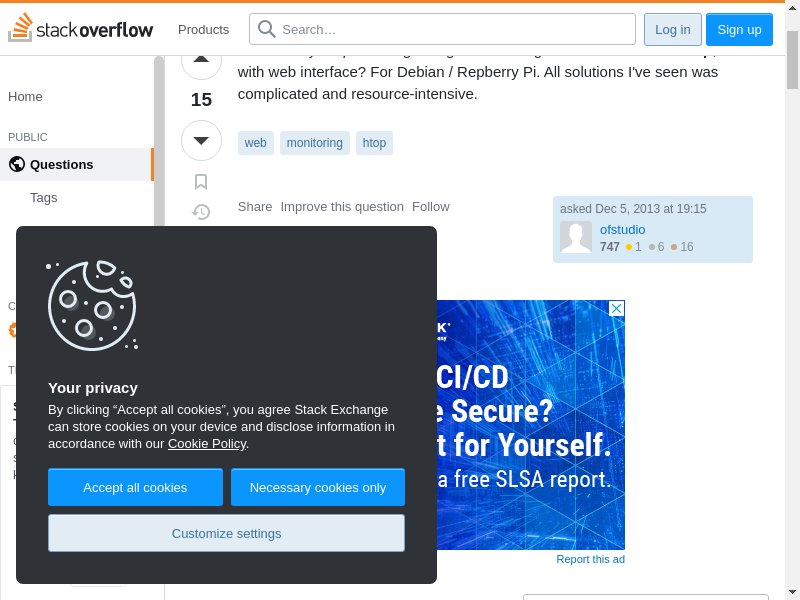

In [35]:
class ScrollUp(ToolInterface):
    """Scroll up the web page by half the screen height"""

    name = "Scroll Up"
    description = "Scroll up the web page by half the screen height"

    def use(self, web_driver: object) -> None:
        # Get the height of the viewport
        viewport_height = web_driver.execute_script("return window.innerHeight")

        # Calculate the scroll distance (half the screen height)
        scroll_distance = viewport_height // 2

        # Scroll up the web page
        web_driver.execute_script(f"window.scrollBy(0, -{scroll_distance});")

example_tool(ScrollUp,site="https://stackoverflow.com/a/20464320")

<ipython-input-21-71a29cc62e3a>:10: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  chrome_options.headless = True


Before,After
,

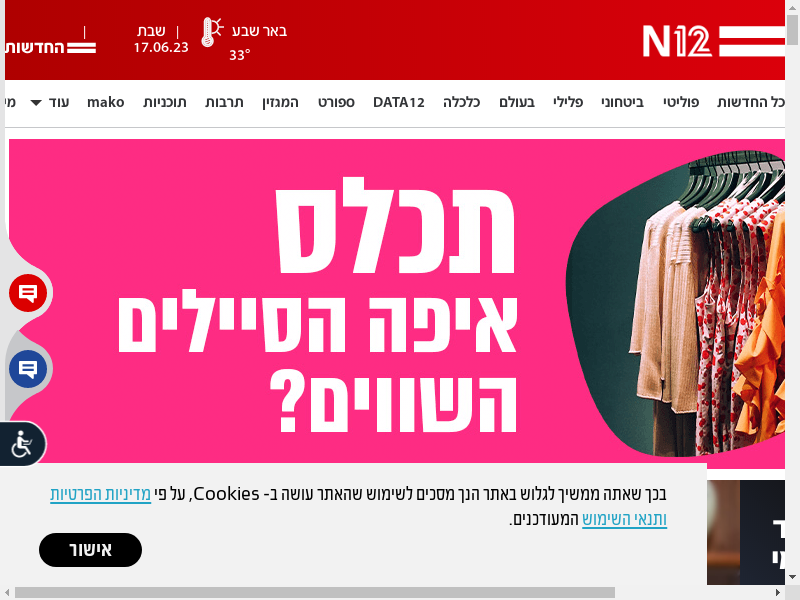
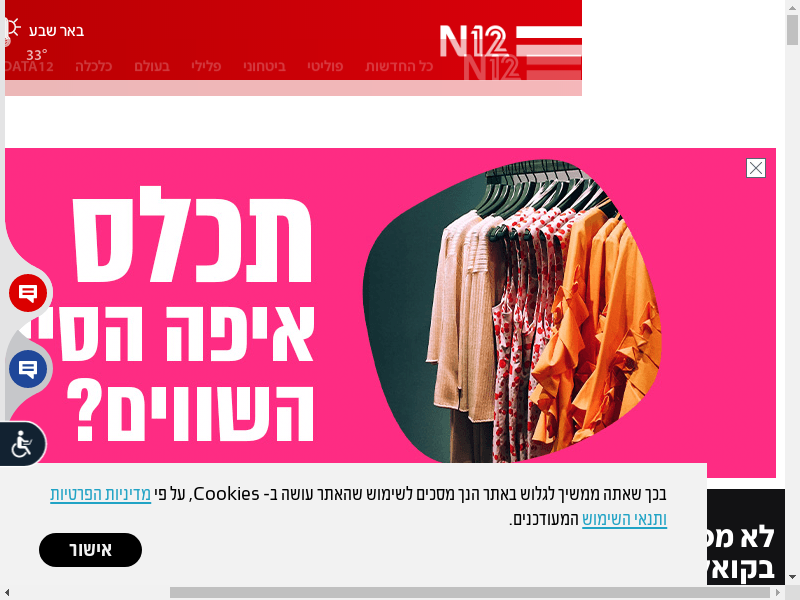

In [41]:
class ScrollRight(ToolInterface):
    """Scroll the web page to the right by half the screen width"""

    name = "Scroll Right"
    description = "Scroll the web page to the right by half the screen width"

    def use(self, web_driver: object) -> None:
        # Get the width of the viewport
        viewport_width = web_driver.execute_script("return window.innerWidth")

        # Calculate the scroll distance (half the screen width)
        scroll_distance = viewport_width // 2

        # Scroll the web page to the right
        web_driver.execute_script(f"window.scrollBy({scroll_distance}, 0);")

example_tool(ScrollRight,site="https://www.n12.co.il/")

In [ ]:

class ScrollLeft(ToolInterface):
    """Scroll the web page to the left by half the screen width"""

    name = "Scroll Left"
    description = "Scroll the web page to the left by half the screen width"

    def use(self, web_driver: object) -> None:
        # Get the width of the viewport
        viewport_width = web_driver.execute_script("return window.innerWidth")

        # Calculate the scroll distance (half the screen width)
        scroll_distance = viewport_width // 2

        # Scroll the web page to the left
        web_driver.execute_script(f"window.scrollBy(-{scroll_distance}, 0);")


In [ ]:
# class EnterText(ClickOnCoordinates):
#     """Click on a field and enter text"""

#     name = "Enter Text"
#     description = "Click on a field and enter text"

#     def use(self, web_driver: object, x:float,y:float, text: str) -> None:
#         # Find the field element
#         super().use(web_driver,x,y)

#         # Click on the field to focus it
#         field_element.click()

#         # Clear the field (optional)
#         field_element.clear()

#         # Enter the text
#         field_element.send_keys(text)


# AutoAgent



In [31]:
import openai
import os

from pydantic import BaseModel
from typing import List


class ChatLLM(BaseModel):
    model: str = 'gpt-3.5-turbo'
    temperature: float = 0.0
    openai.api_key =

    def generate(self, prompt: str, stop: List[str] = None):
        response = openai.ChatCompletion.create(
            model=self.model,
            messages=[{"role": "user", "content": prompt}],
            temperature=self.temperature,
            stop=stop
        )
        return response.choices[0].message.content

In [40]:
import datetime
import re

from pydantic import BaseModel
from typing import List, Dict, Tuple


FINAL_ANSWER_TOKEN = "Final Answer:"
OBSERVATION_TOKEN = "Observation:"
THOUGHT_TOKEN = "Thought:"
PROMPT_TEMPLATE = """

Today is {today}, The site i'm looking on is {site_url}, Here is a representation of what is see on my screen in a table shape.

{on_screen_data}

You should accomplish the task given to you as best as you can using the following tools:

{tool_description}

Use the following format:

Question: the input question you must answer
Thought: comment on what you want to do next
Action: the action to take, exactly one element of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation repeats N times, use it until you are sure of the answer)
Thought: I now know the final answer
Final Answer: your final answer to the original input question

Begin!

Task To Accomplish: {task_to_accomplish}
Thought: {previous_responses}
"""


class Agent(BaseModel):
    llm: ChatLLM
    webdriver : object
    tools: List[ToolInterface]
    prompt_template: str = PROMPT_TEMPLATE
    max_loops: int = 1
    # The stop pattern is used, so the LLM does not hallucinate until the end
    stop_pattern: List[str] = [f'\n{OBSERVATION_TOKEN}', f'\n\t{OBSERVATION_TOKEN}']

    @property
    def tool_description(self) -> str:
        return "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])

    @property
    def tool_names(self) -> str:
        return ",".join([tool.name for tool in self.tools])

    @property
    def tool_by_names(self) -> Dict[str, ToolInterface]:
        return {tool.name: tool for tool in self.tools}

    def run(self, task_to_accomplish: str, url:str):
        webdriver = start_browesr()
        try:
            webdriver.get(url)
            previous_responses = []
            num_loops = 0
            on_screen = screen_to_table(webdriver)
            web_driver_to_image(webdriver,prefix="step_0")
            prompt = self.prompt_template.format(
                    today = datetime.date.today(),
                    tool_description=self.tool_description,
                  tool_names=self.tool_names,
                  task_to_accomplish=task_to_accomplish,
                  on_screen_data="{on_screen_data}",
                  previous_responses='{previous_responses}',
                  site_url=url
            )

            while num_loops < self.max_loops:
                num_loops += 1

                curr_prompt = prompt.format(previous_responses='\n'.join(previous_responses),
                                            on_screen_data=on_screen.to_csv(index=False)
                )
                print(curr_prompt)


                generated, tool, tool_input = self.decide_next_action(curr_prompt)
                if tool == 'Final Answer':
                    return tool_input
                if tool not in self.tool_by_names:
                    raise ValueError(f"Unknown tool: {tool}")

                print('------')
                print(webdriver)
                print(generated)

                webdriver = self.tool_by_names[tool].use(webdriver,tool_input)
                on_screen = screen_to_table(webdriver)
                web_driver_to_image(webdriver,prefix=f"step_{str(num_loops+1)}")
                generated += f"\n{OBSERVATION_TOKEN} \n{THOUGHT_TOKEN}"

                previous_responses.append(generated)
        except Exception as e:
                if webdriver:
                  webdriver.close()
                raise e


    def decide_next_action(self, prompt: str) -> str:
        generated = self.llm.generate(prompt, stop=self.stop_pattern)

        tool, tool_input = self._parse(generated)
        return generated, tool, tool_input

    def _parse(self, generated: str) -> Tuple[str, str]:
        if FINAL_ANSWER_TOKEN in generated:
            return "Final Answer", generated.split(FINAL_ANSWER_TOKEN)[-1].strip()

        regex = r"Action: [\[]?(.*?)[\]]?[\n]*Action Input:[\s]*(.*)"
        match = re.search(regex, generated, re.DOTALL)
        if not match:
            raise ValueError(f"Output of LLM is not parsable for next tool use: `{generated}`")
        tool = match.group(1).strip()
        tool_input = match.group(2)
        return tool, tool_input.strip(" ").strip('"')

In [45]:
agent = Agent(llm=ChatLLM(), tools=[GoToURL(),ClickOnCoordinates()])
agent.run("Log into my Gmail account","https://www.google.com")

<ipython-input-39-8840b3b0eece>:10: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  chrome_options.headless = True


https://www.google.com/


Today is 2023-06-17, The site i'm looking on is https://www.google.com, Here is a representation of what is see on my screen in a table shape.

X,Y,Width,Height,ElementType,textContent,TooltipValue,AriaLabel
21.0,17,40.34375,26,A,undefined,,
71.34375,17,43.46875,26,A,undefined,,
482.421875,18,33.953125,24,A,undefined,,Gmail (opent een nieuw tabblad)
531.375,18,75.90625,24,A,undefined,,Zoeken naar afbeeldingen (opent een nieuw tabblad)
626.28125,10,40.0,40,A,undefined,,Google-apps
702.28125,22,55.71875,16,SPAN,undefined,,
264.0,60,272.0,92,DIV,undefined,,
123.0,179,33.0,46,DIV,undefined,,
156.0,190,443.0,27,TEXTAREA,undefined,Zoeken,Zoek
603.0,179,40.0,44,DIV,undefined,,Gesproken zoekopdracht
643.0,179,40.0,44,DIV,undefined,,Zoeken op afbeelding
266.25,255,129.734375,36,INPUT,undefined,,Google Zoeken
407.875,255,125.859375,36,INPUT,undefined,,Ik doe een gok
424.375,318,37.78125,15,A,undefined,,
465.78125,318,48.640625,15,A,undefined,,
0.0,459,800.0,48,DIV,undef

In [ ]:
# def display_image(file_name):
#   from IPython.display import Image, display
#   display(Image(filename=file_name))